In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/allen/python3-env/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
# I'm limited by RAM here and taking the first N rows is likely to be
# a bad idea for the date data since it is ordered.
# Sample the data in a roundabout way:
date_chunks = pd.read_csv("train_date.csv", index_col=0, chunksize=100000, dtype=np.float32)
num_chunks = pd.read_csv("train_numeric.csv", index_col=0, usecols=list(range(969)), chunksize=100000, dtype=np.float32)

X_part = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05) for dchunk, nchunk in zip(date_chunks, num_chunks)])
y_part = pd.read_csv("train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[X_part.index].values.ravel()
#X_part = X_part.values

In [41]:
y_part = pd.read_csv("train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[X_part.index].values.ravel()

/Users/allen/python3-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [39]:
type(X_part.index)

pandas.core.indexes.numeric.Float64Index

In [8]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[  76  169  421  883 1018 1019 1029 1042 1056 1097 1165 1166 1168 1171 1187
 1191 1194 1213 1218 1221 1228 1247 1269 1272 1315 1447 1449 1497 1508 1516
 1520 1548 1549 1550 1843 1846 1862 1882 1891 1913 1936 1937 1942 1944 1955
 1959 1960 1961 1962 1982 1983 1985 1986 1988 1994 1995 2006 2007 2010 2020
 2022 2089 2107 2114]


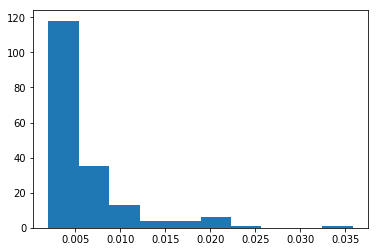

In [9]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [14]:
a = np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])

In [15]:
a

array([   0,   77,  170,  422,  884, 1019, 1020, 1030, 1043, 1057, 1098])

In [10]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values
], axis=1)
y = pd.read_csv("train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

/Users/allen/python3-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.718
fold 1, ROC AUC: 0.697
fold 2, ROC AUC: 0.690
0.701206696679


0.212023938794


/Users/allen/python3-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


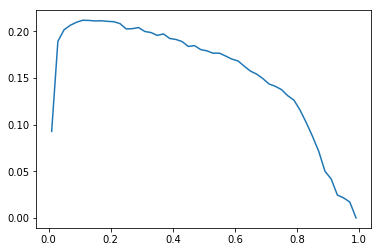

In [16]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [17]:
# load test data
X = np.concatenate([
    pd.read_csv("test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values
], axis=1)

/Users/allen/python3-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [19]:
# and submit
sub = pd.read_csv("sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")

/Users/allen/python3-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
